In [26]:
import os
import numpy as np

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [27]:
from dataloaders import loadfile

dac = loadfile(f"{HOME}/Datasets/cell_migration/dac.txt")
msd = loadfile(f"{HOME}/Datasets/cell_migration/msd.txt")
params = loadfile(f"{HOME}/Datasets/cell_migration/parameters.txt")

SyntaxError: invalid syntax (<string>, line 0)

In [6]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator


def collate_fn():
    ...


prior = Prior(prior_fun=params.__next__, param_names=["A", "B", "C", "D", "E"])
simulator = Simulator(simulator_fun=collate_fn)

prior_means, prior_stds = prior.estimate_means_and_stds()
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

print(prior_means, prior_stds)

INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 80, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


[[ 1.47655815  1.47929192  1.48780488  1.50690028 13.39114469]] [[ 2.36635041  2.25326833  2.38332821  2.31952007 22.24352688]]


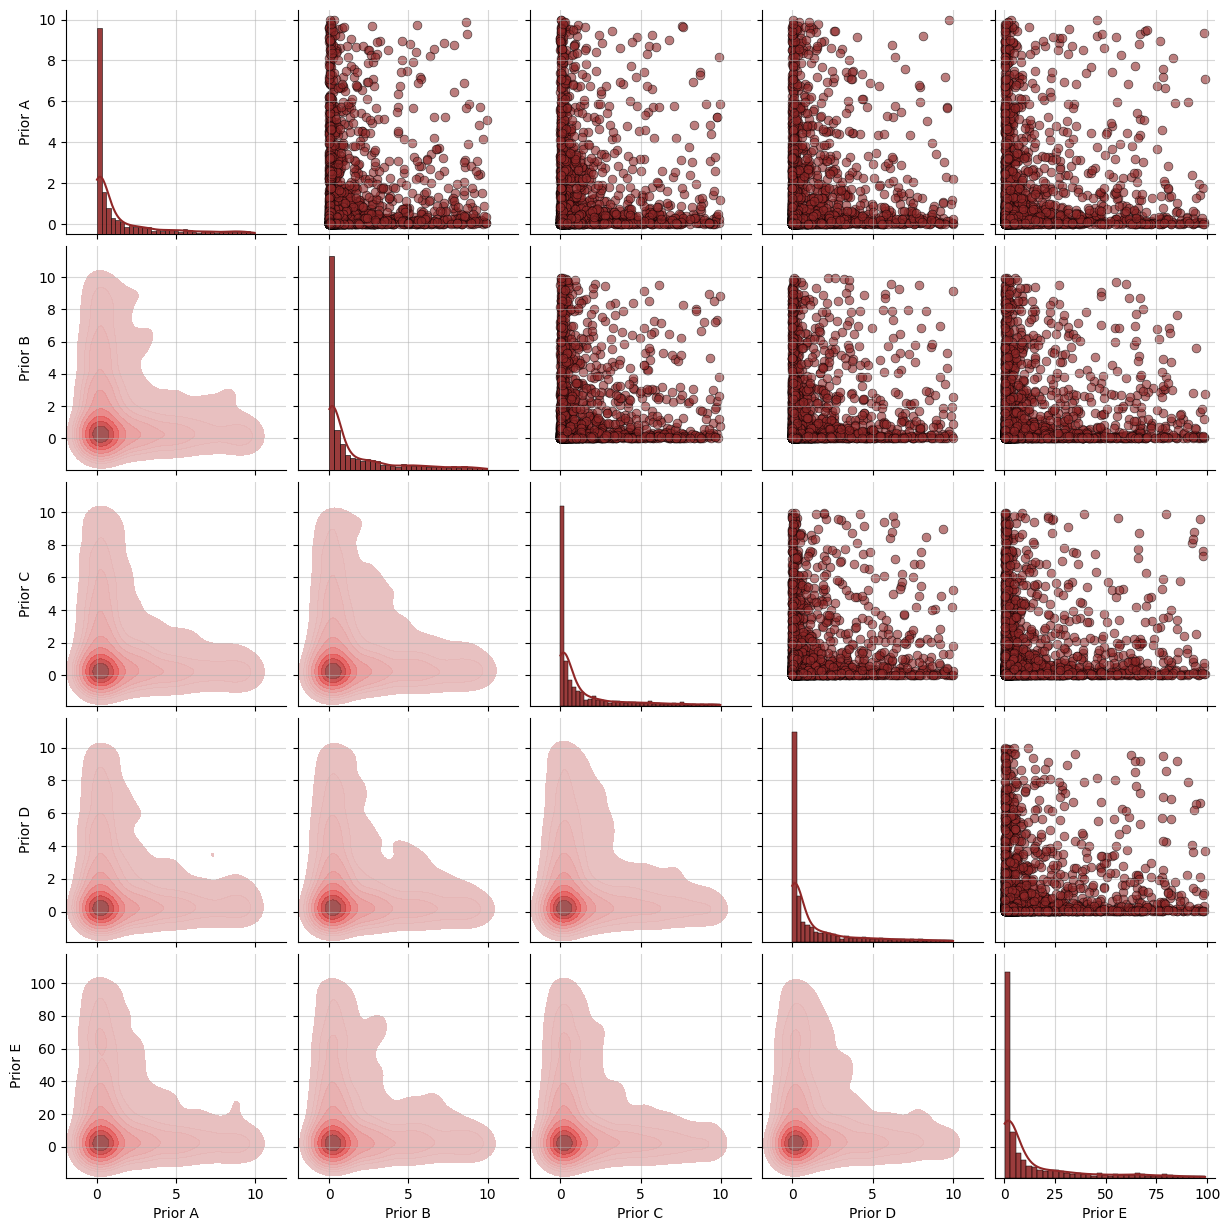

In [7]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [8]:
from bayesflow.networks import InvertibleNetwork, TimeSeriesTransformer
from bayesflow.amortizers import AmortizedPosterior

In [9]:
summary_net = TimeSeriesTransformer(input_dim=1)

In [10]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [11]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [12]:
from bayesflow.trainers import Trainer

def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Convert data to logscale
    data = forward_dict["sim_data"].astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Remove a batch if it contains nan, inf or -inf
    # idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    # if not np.all(idx_keep):
    #     print("Invalid value encountered...removing from batch")

    return {
        "summary_conditions": data,
        "parameters": params
    }

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [13]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  297080    
 ibleNetwork)                                                    
                                                                 
 time_series_transformer (T  multiple                  57878     
 imeSeriesTransformer)                                           
                                                                 
Total params: 354958 (1.35 MB)
Trainable params: 354918 (1.35 MB)
Non-trainable params: 40 (160.00 Byte)
_________________________________________________________________


In [14]:
# %%time
_ = model(32)

In [15]:
offline_data = model(10000)
print(offline_data)

{'prior_non_batchable_context': None, 'prior_batchable_context': None, 'prior_draws': array([[2.36177301, 0.09246713, 0.04556517, 5.96844106, 1.07264555],
       [0.04230695, 0.40796782, 5.94727049, 0.02177342, 0.63966517],
       [7.51958803, 0.03477488, 4.67610108, 1.20261515, 0.32388589],
       ...,
       [0.03261287, 0.01095737, 5.69730217, 0.06227681, 0.62699577],
       [0.22979216, 0.63127997, 0.0304067 , 0.04787154, 0.90260683],
       [1.2499126 , 0.13648204, 0.01394605, 0.04593247, 3.74059622]]), 'sim_non_batchable_context': None, 'sim_batchable_context': None, 'sim_data': array([[[ 4.65661287e-10],
        [ 1.28413683e+01],
        [ 2.90328715e+01],
        ...,
        [ 9.72621594e+01],
        [ 1.80179212e+02],
        [ 2.65936399e+02]],

       [[ 5.96046448e-08],
        [ 6.17921883e+02],
        [ 2.16633225e+03],
        ...,
        [ 2.47688212e+06],
        [ 2.53926921e+06],
        [ 2.61148793e+06]],

       [[-5.96046448e-08],
        [ 9.46046416e+02],


In [16]:
# %%time
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 313/313 [00:18<00:00, 16.91it/s, Epoch: 1, Batch: 313,Loss: 6.656,W.Decay: 0.105,Avg.Loss: 7.046,Avg.W.Decay: 0.149,LR: 4.99E-04]
INFO:root:Validation, Epoch: 1, Loss: 7.097
Training epoch 2: 100%|██████████| 313/313 [00:10<00:00, 30.83it/s, Epoch: 2, Batch: 313,Loss: 6.960,W.Decay: 0.067,Avg.Loss: 7.035,Avg.W.Decay: 0.084,LR: 4.95E-04]
INFO:root:Validation, Epoch: 2, Loss: 7.101
Training epoch 3: 100%|██████████| 313/313 [00:10<00:00, 31.21it/s, Epoch: 3, Batch: 313,Loss: 3.866,W.Decay: 0.067,Avg.Loss: 6.214,Avg.W.Decay: 0.063,LR: 4.88E-04]
INFO:root:Validation, Epoch: 3, Loss: 4.531
Training epoch 4: 100%|██████████| 313/313 [00:10<00:00, 29.10it/s, Epoch: 4, Batch: 313,Loss: 3.781,W.Decay: 0.072,Avg.Loss: 3.797,Avg.W.Decay: 0.070,LR: 4.78E-04]
INFO:root:Validation, Epoch: 4, Loss: 3.097
Training epoch 5: 100%|██████████| 313/313 [00:10<00:00, 29.51it/s, Epoch: 5, Batch: 313,Loss: 2.979,W.Decay: 0.

/Users/alisamar/Desktop/cell_migration/.venv/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


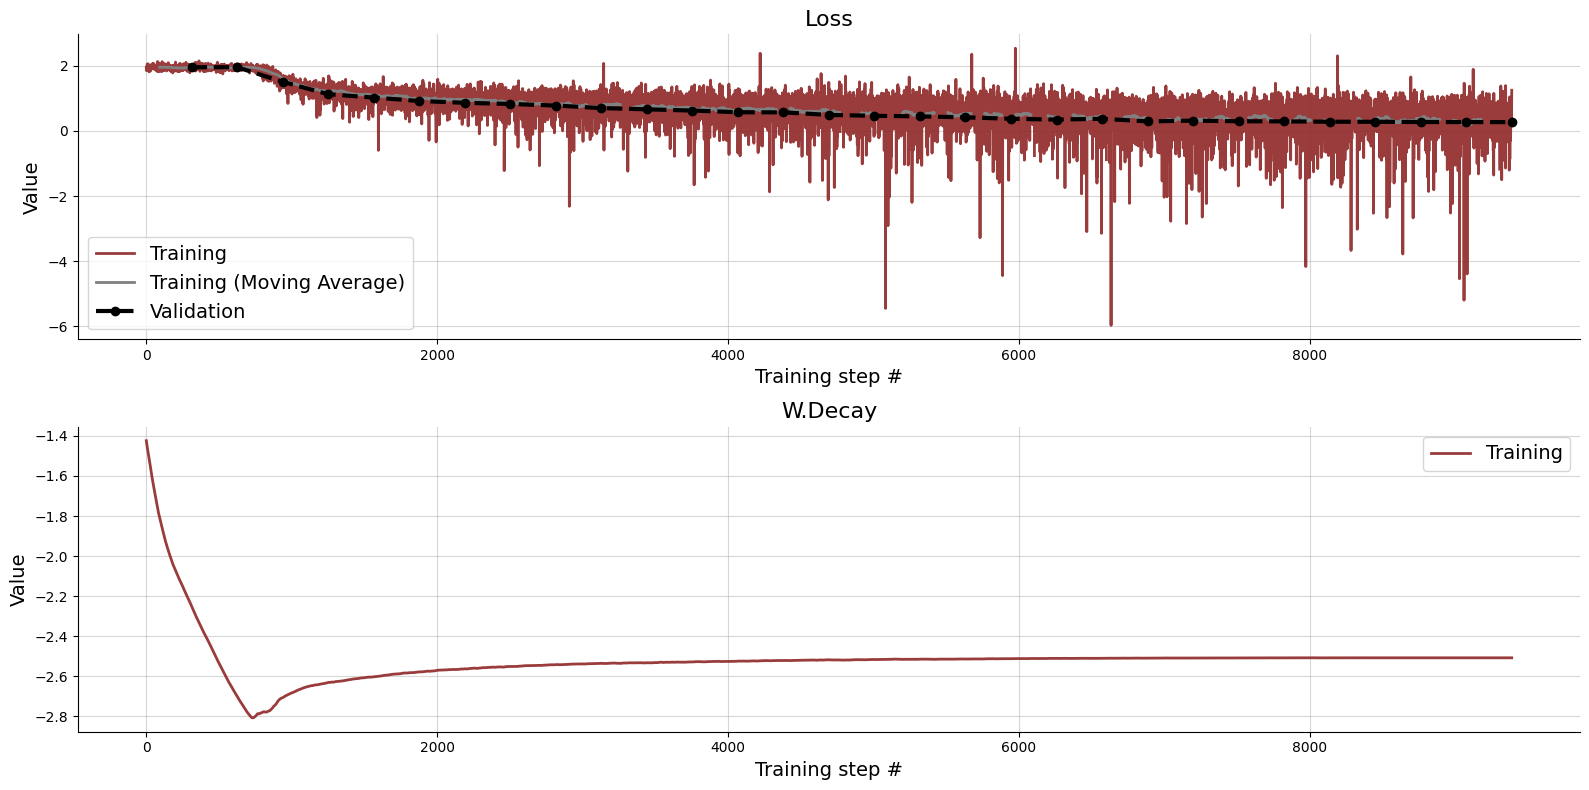

In [17]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

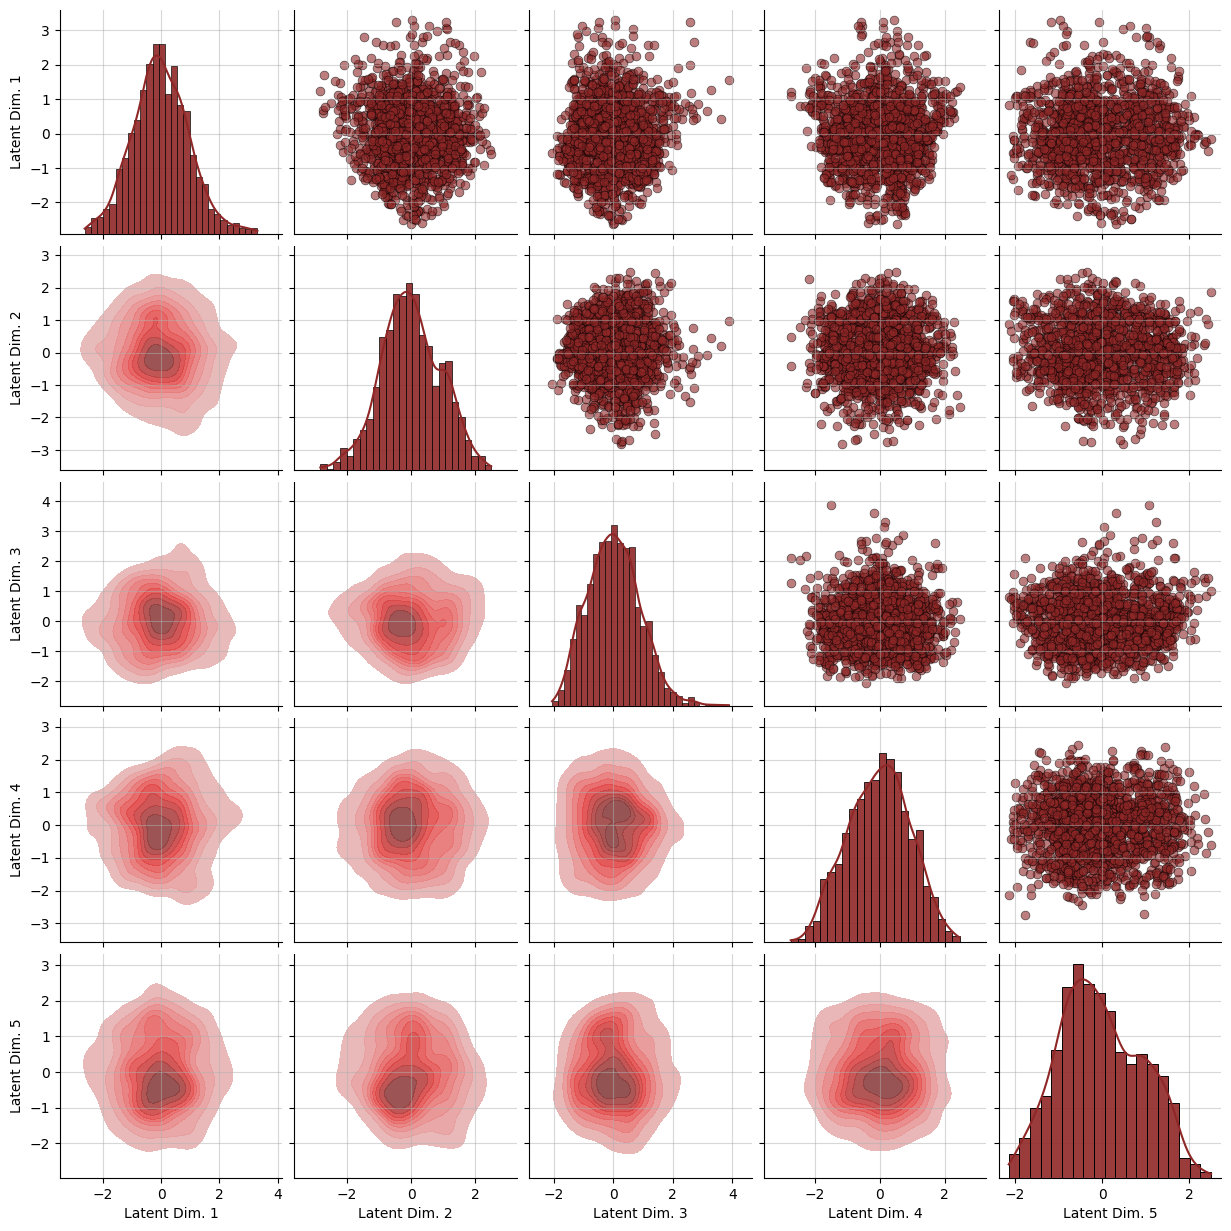

In [18]:
f = trainer.diagnose_latent2d()

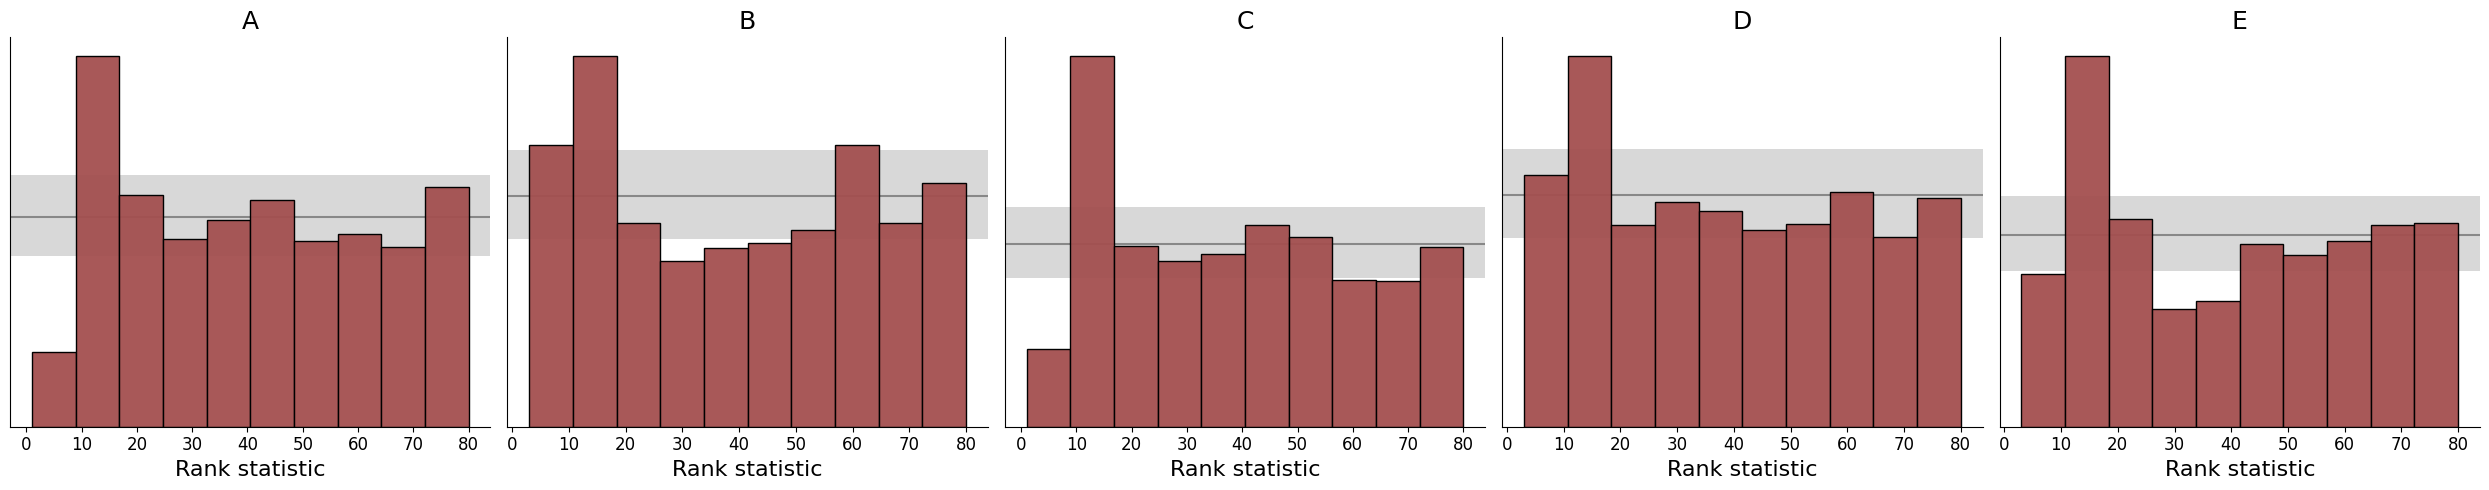

In [19]:
f = trainer.diagnose_sbc_histograms()

In [20]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

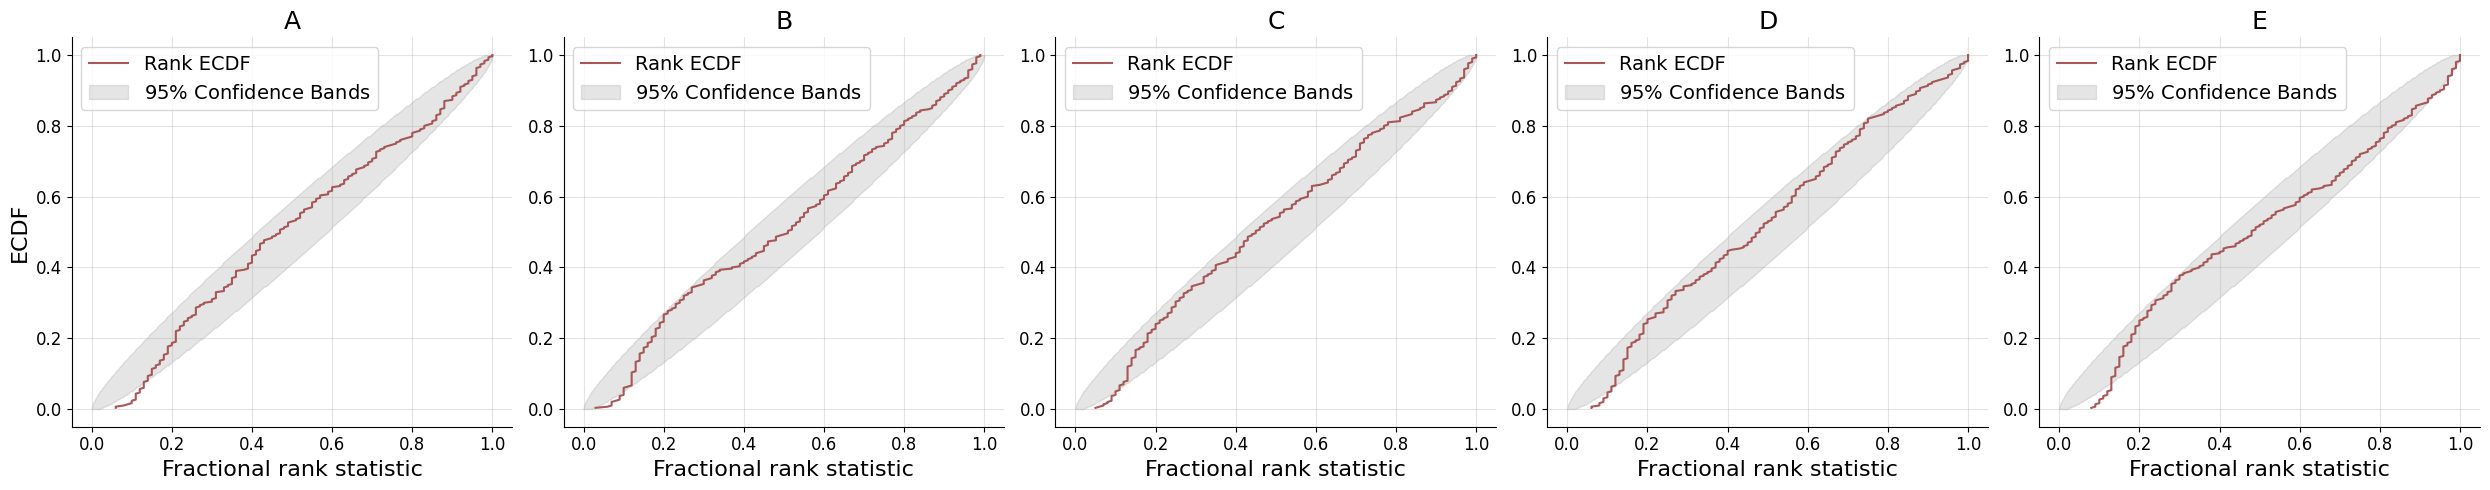

In [21]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

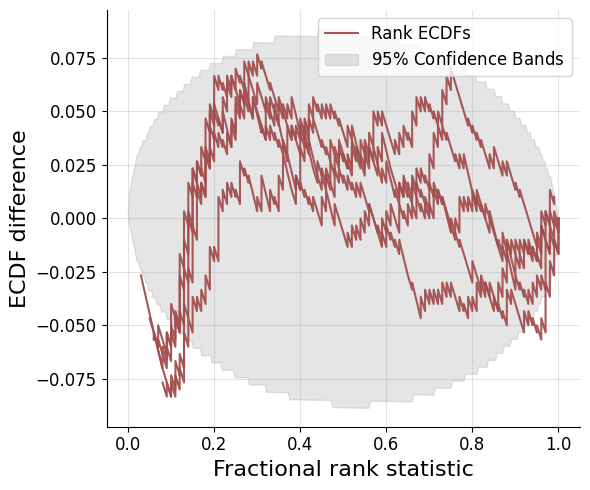

In [22]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


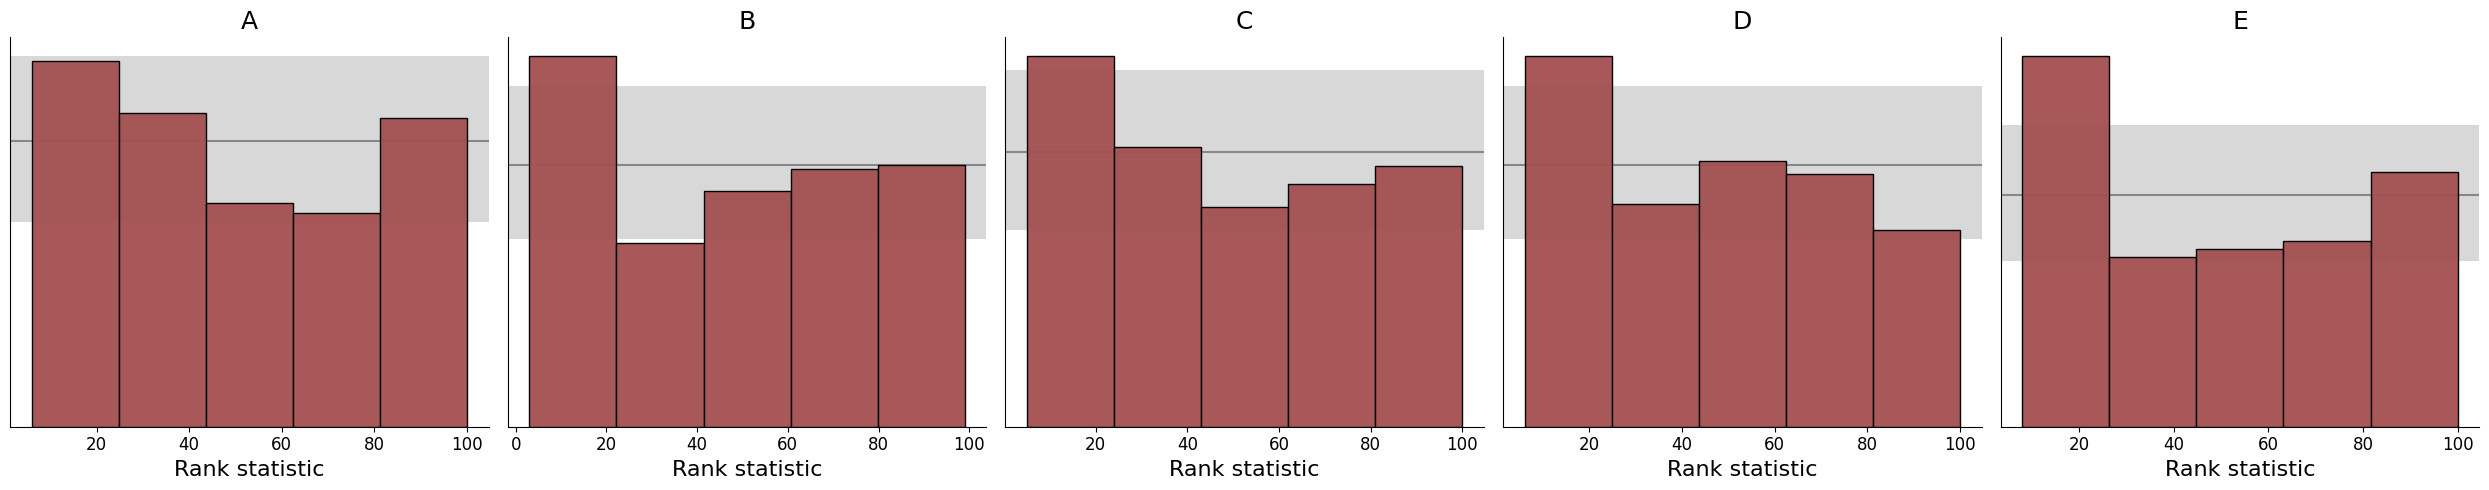

In [23]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

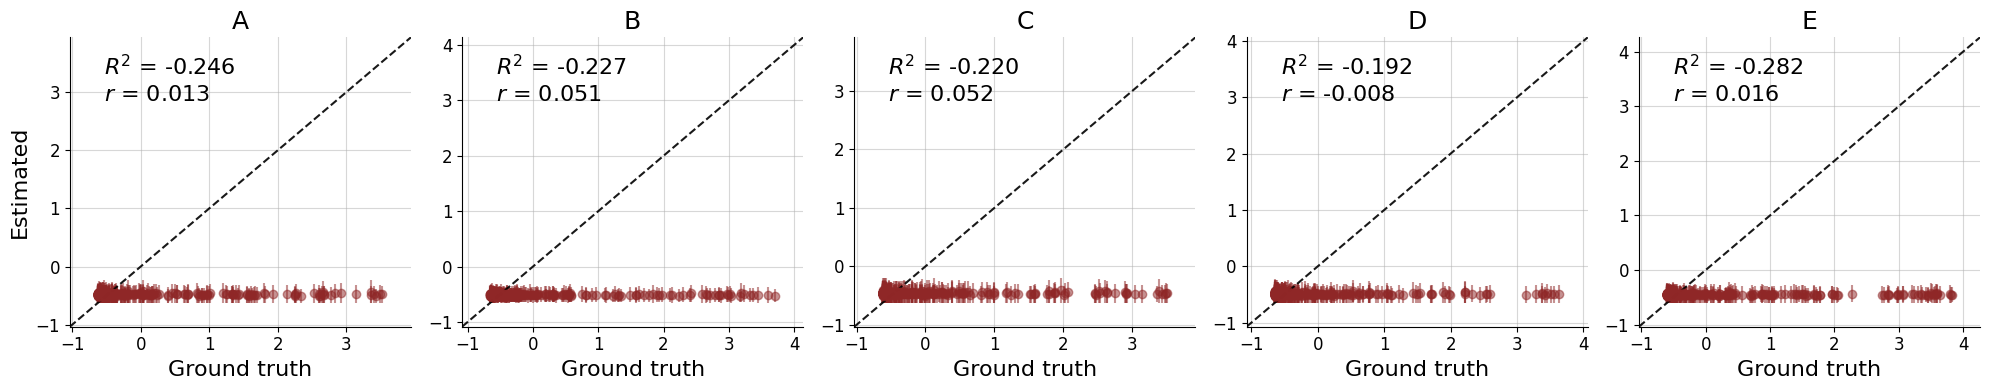

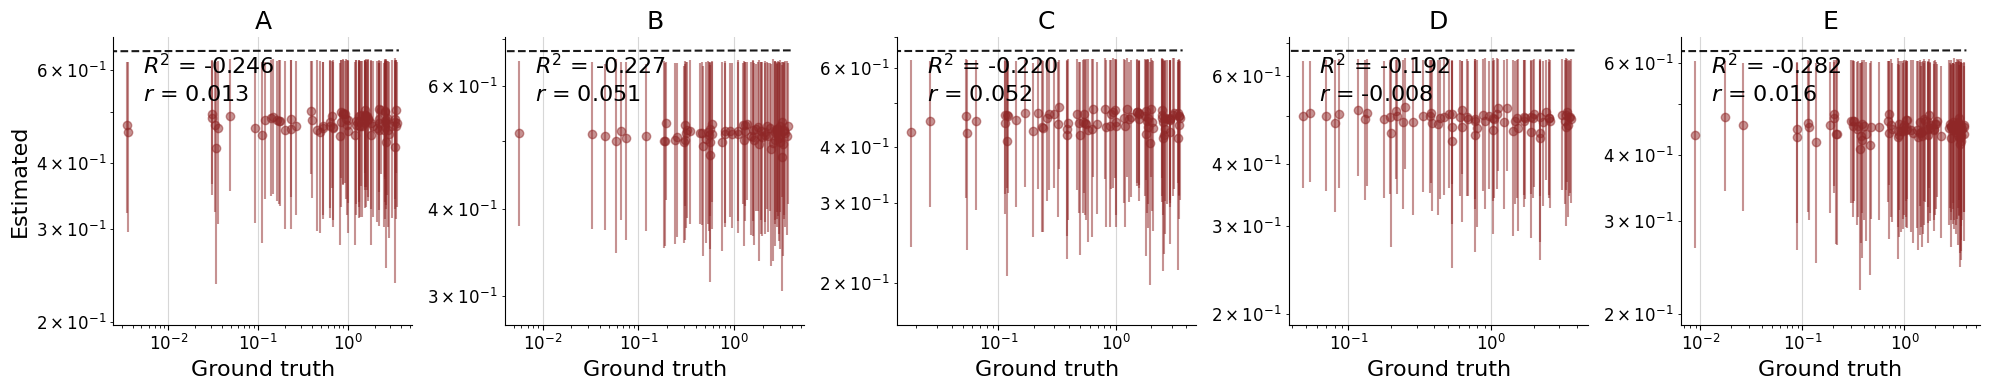

In [25]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)
f = plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)